### Import the packages

In [5]:
# General
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
import json

# Images
import cv2
#import dlib
from PIL import Image
import Augmentor

# Training
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# Testing
from tensorflow.keras.models import load_model, save_model

from mae_callback import MAECallback
from mae_callback import get_mae
import config


/Users/shreehariboyalla/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shreehariboyalla/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shreehariboyalla/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shreehariboyalla/.local/lib/python3.6/site-packages

In [6]:
config.ORIGINAL_IMGS_DIR
config.col = 2

In [7]:
config.ORIGINAL_IMGS_INFO_FILE 

'prisoners.csv'

# 1. Face detection

In [8]:
config.CROPPED_IMGS_DIR 

config.CROPPED_IMGS_INFO_FILE = 'prisoners.csv'

#### Definition of cropping & saving functions

In [5]:
t = []
def crop_faces(plot_images=False, max_images_to_plot=5, face_align=False):
    
    not_crop_count = 0 # count the number of faces that have not been detected by detector
    
    # We create a directory to stock the cropped images
    if not os.path.exists(config.CROPPED_IMGS_DIR):
        os.makedirs(config.CROPPED_IMGS_DIR) 
    
    # Open file with info
    with open(config.ORIGINAL_IMGS_INFO_FILE, 'r') as f:
        column_headers = f.read().splitlines()[0]
        print(column_headers)
    with open(config.ORIGINAL_IMGS_INFO_FILE, 'r') as f:
        all_imgs_info = f.read().splitlines()[1:]
        #print(np.shape(all_imgs_info))
    
    
    # Start the cropping
    print('Cropping faces and saving to %s', config.CROPPED_IMGS_DIR)
    good_cropped_img_file_names = []
    original_images_detected = []
    cropped_imgs_info=[]
    it=0
    
    for file_name in sorted(os.listdir(config.ORIGINAL_IMGS_DIR)):
        if file_name == '.DS_Store':
            print(file_name)
            continue
        np_img = cv2.imread(os.path.join(config.ORIGINAL_IMGS_DIR,file_name))
        if file_name[0]=='T':
            continue
        
        # Face alignment
        if face_align==True:
            np_img=face_alignment(np_img)
        gray=cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale (gray, 1.1, 4) # Here we detect the faces from the original images
        img_h, img_w, _ = np.shape(np_img)
        original_images_detected.append(np_img)

        if len(faces) != 1:
            not_crop_count += 1
            print('NO face detected in', file_name)
            t.append(file_name)
            it+=1
            
            if config.ORIGINAL_IMGS_DIR == 'vipp':
                # Just for VIP dataset, not crop needed
                norm_file_path = '%s/%s' % (config.CROPPED_IMGS_DIR, file_name)
                cv2.imwrite(norm_file_path, np_img)
                cropped_imgs_info.append(all_imgs_info[it])
            
            continue # If no face, we jump to the beginning of the loop again

        for(x1 , y1,  w1,  h1) in faces:
            xw1 = int(x1 - config.MARGIN * (x1+w1))
            yw1 = int(y1 - config.MARGIN * (y1+w1))
            xw2 = int((x1+w1) + config.MARGIN * (x1+w1))
            yw2 = int((y1+w1) + config.MARGIN * (y1+w1))
        
        cropped_img = crop_image(np_img, xw1, yw1, xw2, yw2) # We apply the cropping function defined below
        
        norm_file_path = '%s/%s' % (config.CROPPED_IMGS_DIR, file_name)
        cv2.imwrite(norm_file_path, cropped_img)

        good_cropped_img_file_names.append(file_name)
        
        # Add info of good cropped images for later
        cropped_imgs_info.append(all_imgs_info[it])
        
        it+=1
    
                
    # Save the info of the data with cropped faces in a file
    with open(config.CROPPED_IMGS_INFO_FILE, 'w') as f:
        f.write('%s\n' % column_headers)
        for l in cropped_imgs_info:
            f.write('%s\n' % l)
            

def face_alignment(img):
    
    roi_color=img
    roi_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # EYES DETECTION
    # Creating variable eyes
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 4)
    index=0
    
    if np.shape(eyes)[0]>=2:
    
        # Creating for loop in order to divide one eye from another
        for (ex , ey,  ew,  eh) in eyes:
            if index == 0:
                eye_1 = (ex, ey, ew, eh)
            elif index == 1:
                eye_2 = (ex, ey, ew, eh)
            index = index + 1
            
        if eye_1[0] < eye_2[0]:
            left_eye = eye_1
            right_eye = eye_2
        else:
            left_eye = eye_2
            right_eye = eye_1
    
    # EYE CENTER COMPUTATION
    # Calculating coordinates of a central points of the rectangles
        left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
        left_eye_x = left_eye_center[0] 
        left_eye_y = left_eye_center[1]
 
        right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
        right_eye_x = right_eye_center[0]
        right_eye_y = right_eye_center[1]
    
    # ANGLE COMPUTATION
        if left_eye_y > right_eye_y:
            A = (right_eye_x, left_eye_y)
    # Integer -1 indicates that the image will rotate in the clockwise direction
            direction = -1 
        else:
            A = (left_eye_x, right_eye_y)
          # Integer 1 indicates that image will rotate in the counter clockwise  
          # direction
            direction = 1 
        
        # Angle
        delta_x = right_eye_x - left_eye_x
        delta_y = right_eye_y - left_eye_y
        angle=np.arctan(delta_y/delta_x)
        angle = (angle * 180) / np.pi
    
    # Width and height of the image
        h, w = img.shape[:2]
    # Calculating a center point of the image
    # Integer division "//"" ensures that we receive whole numbers
        center = (w // 2, h // 2)
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
        if angle>10:
            angle=0
        if angle<-10:
            angle=0
        
        M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    # Applying the rotation to our image using the
    # cv2.warpAffine method
        alig_img = cv2.warpAffine(img, M, (w, h))
        
    else:
        alig_img=img
    
    return alig_img
            

def crop_image(img, x1, y1, x2, y2):
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = cv2.copyMakeBorder(img, - min(0, y1), max(y2 - img.shape[0], 0), -min(0, x1), max(x2 - img.shape[1], 0), cv2.BORDER_REPLICATE)
    y2 += -min(0, y1)
    y1 += -min(0, y1)
    x2 += -min(0, x1)
    x1 += -min(0, x1)
    return img, x1, x2, y1, y2

#### Crop & saving

In [6]:
# Load the face detector
print(config.ORIGINAL_IMGS_DIR)
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade=cv2.CascadeClassifier("haarcascade_eye.xml")

crop_faces(plot_images=False,face_align=False)

prisoners
,age,weight,Race,sex,eyes,hair,image
Cropping faces and saving to %s crop_prisoners
.DS_Store
NO face detected in s_0022.jpg
NO face detected in s_0064.jpg
NO face detected in s_0074.jpg
NO face detected in s_0082.jpg
NO face detected in s_0119.jpg
NO face detected in s_0129.jpg
NO face detected in s_0134.jpg
NO face detected in s_0157.jpg
NO face detected in s_0159.jpg
NO face detected in s_0196.jpg
NO face detected in s_0203.jpg
NO face detected in s_0205.jpg
NO face detected in s_0230.jpg
NO face detected in s_0239.jpg
NO face detected in s_0240.jpg
NO face detected in s_0295.jpg
NO face detected in s_0370.jpg


IndexError: list index out of range

# 2. Face augmentation

#### Functions for image augmentation

In [9]:
# Function to plot images that are generated by our 2 generators train_generator and validation_generator
def plot_imgs_from_generator(generator, number_imgs_to_show):
    print ('Plotting images...')
    n_rows_cols = int(math.ceil(math.sqrt(number_imgs_to_show)))
    plot_index = 1
    x_batch, _ = next(generator)
    while plot_index <= number_imgs_to_show:
        plt.subplot(n_rows_cols, n_rows_cols, plot_index)
        plt.imshow(x_batch[plot_index-1])
        plot_index += 1
    plt.show()

# Function that randomizes the process
def augment_image(np_img):
    p = Augmentor.Pipeline()
    #p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
    p.flip_left_right(probability=0.5)
    p.random_distortion(probability=0.25, grid_width=2, grid_height=2, magnitude=8)
    p.random_color(probability=1, min_factor=0.8, max_factor=1.2)
    p.random_contrast(probability=.5, min_factor=0.8, max_factor=1.2)
    p.random_brightness(probability=1, min_factor=0.5, max_factor=1.5)

    image = [Image.fromarray(np_img.astype('uint8'))]
    for operation in p.operations:
        r = round(random.uniform(0, 1), 1)
        if r <= operation.probability:
            image = operation.perform_operation(image)
    image = [np.array(i).astype('float64') for i in image]
    return image[0]

#### Create 2 generators: train and validation.

/Users/shreehariboyalla/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shreehariboyalla/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 350 validated image filenames.
Found 30 validated image filenames.
Plotting images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

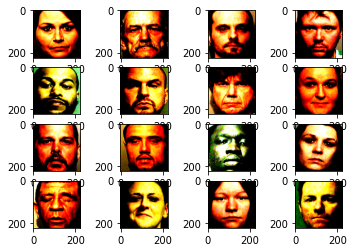

Plotting images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

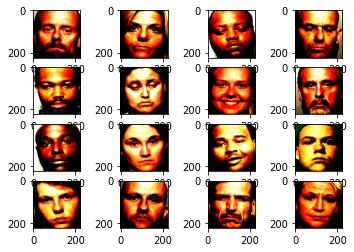

In [10]:
# Here we define the technique/method
image_processor = ImageDataGenerator(rescale=1./255, 
                                     samplewise_center=True, 
                                     samplewise_std_normalization=True, 
                                     preprocessing_function=augment_image)
image_processor_woa = ImageDataGenerator(rescale=1./255)

# Subtract validation size from training data
with open(config.CROPPED_IMGS_INFO_FILE) as f:
    for i, _ in enumerate(f):
        pass
    training_n = i - config.VALIDATION_SIZE - config.TEST_SIZE
    
#Here we have training_n available images for the training part
#train_df=pd.read_csv(config.CROPPED_IMGS_INFO_FILE, nrows=training_n, sep=',')
#validation_df=pd.read_csv(config.CROPPED_IMGS_INFO_FILE, header=0,
                          #skiprows=range(1,training_n), nrows=config.VALIDATION_SIZE, sep=',')

train_df=pd.read_csv(config.CROPPED_IMGS_INFO_FILE, header=0,
                          skiprows=range(1,config.TEST_SIZE+config.VALIDATION_SIZE), nrows=training_n, sep=',')

validation_df=pd.read_csv(config.CROPPED_IMGS_INFO_FILE, header=0,
                          skiprows=range(1,config.TEST_SIZE), nrows=config.VALIDATION_SIZE, sep=',')





# Setting the good format for the X and y data
for l in range(0,training_n):
    train_df['image'][l] = train_df['image'][l] + '.jpg'

for l in range(0,config.VALIDATION_SIZE):
    validation_df['image'][l] = validation_df['image'][l] + '.jpg'
    
train_df['weight'] = train_df['weight'].astype(int)
validation_df['weight'] = validation_df['weight'].astype(int)


# We create 2 different generators: the former train_generator will be used to generate training data and the latter validation_generator will be used to generate validation data
train_generator=image_processor.flow_from_dataframe(
    dataframe=train_df,
    directory=config.CROPPED_IMGS_DIR,
    x_col='image',
    y_col=['age','sex', 'Race','weight'],
    class_mode= 'multi_output',
    color_mode='rgb',
    target_size=(config.RESNET50_DEFAULT_IMG_WIDTH,config.RESNET50_DEFAULT_IMG_WIDTH),
    batch_size=config.TRAIN_BATCH_SIZE)

validation_generator=image_processor.flow_from_dataframe(
    dataframe=validation_df,
    directory=config.CROPPED_IMGS_DIR,
    x_col='image',
    y_col=['age', 'sex', 'Race', 'weight'],
    class_mode='multi_output',
    color_mode='rgb',
    target_size=(config.RESNET50_DEFAULT_IMG_WIDTH,config.RESNET50_DEFAULT_IMG_WIDTH),
    batch_size=config.VALIDATION_SIZE)


# Visualize the new images generated
plot_imgs_from_generator(train_generator, config.TRAIN_BATCH_SIZE)
plot_imgs_from_generator(validation_generator, config.TRAIN_BATCH_SIZE)

# 3. Model

## Train

#### Transfer learning from an age model

In [20]:
#K.set_image_data_format('channels_last')

def get_age_model():

# The input shape of our ResNet50 model is (224,224,3)
# We don't include the top of the ResNet50 since we want to add our proper fully connected layer 
# which will eventually contain only 1 neuron for the body mass regression

    age_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(config.RESNET50_DEFAULT_IMG_WIDTH, config.RESNET50_DEFAULT_IMG_WIDTH,3),
        pooling='avg')

    prediction = Dense(units=101,
                       kernel_initializer='he_normal',
                       use_bias=False,
                       activation='softmax',
                       name='pred_age')(age_model.output)

    age_model = Model(inputs=age_model.input, outputs=prediction)
    
    return age_model


def get_model(ignore_age_weights=False):
    
# We use transfer learning from the extensively trained age classifier
    
    base_model = get_age_model()                                
    if not ignore_age_weights:
        base_model.load_weights(config.AGE_TRAINED_WEIGHTS_FILE)
    last_hidden_layer = base_model.get_layer(index=-2)

    base_model = Model(
        inputs=base_model.input,
        outputs=last_hidden_layer.output)
    prediction = Dense(1, kernel_initializer='normal')(base_model.output)

    model = Model(inputs=base_model.input, outputs=prediction)
    return model


#Resnet model with Age trained weights
def auxilary_model_1(ignore_age_weights=False):
    base_model = get_age_model()                                
    if not ignore_age_weights:
        base_model.load_weights(config.AGE_TRAINED_WEIGHTS_FILE)
    return base_model
    
def aux_end(model):
    
    """
    This function, the Rock part is added at the end of the Resnet-50 architecture.
    """
    base_feature = model.get_layer(index=-3) #last layer of resent that has base features
    
#Building Resnet-50 till last Activativation layer
    
    base_model = Model( 
        inputs = model.input, 
        outputs = base_feature.output)
    
#Rock unit for Age estimation(Age module)

    E_age = Conv2D(filters=256, kernel_size=(7,7), name='E_age', padding='same')(base_model.output)
    y_age = GlobalAveragePooling2D(name='E_age_average_pooling')(E_age)
    Output_age=  Dense(1, name='Output_age')(y_age) 

    decoder_output_age= Conv2D(2048, (7,7),  name='D_age', padding='same')(E_age)
   

   
#Rock unit for Gender estimation(Gender module)
    
    E_gender = Conv2D(filters=2, kernel_size=(7,7),  name='E_gender', padding='same')(base_model.output)
    y_gender = GlobalAveragePooling2D(name='E_gender_average_pooling')(E_gender)
    Output_gender=  Dense(2, name='Output_gender', activation='softmax')(y_gender) 

    decoder_output_gender = Conv2D(2048, (7,7),  name='D_gender', padding='same')(E_gender)
    
    
#Rock unit for Race Estimation(Race module)
    E_race = Conv2D(filters=4, kernel_size=(7,7), name='E_race', padding='same')(base_model.output)
    y_race = GlobalAveragePooling2D(name='E_race_average_pooling')(E_race)
    Output_race =  Dense(4, name='Output_race', activation='softmax')(y_race) 

    decoder_output_race = Conv2D(2048, (7,7),  name='D_race', padding='same')(E_race)
    
    
#fusing base feature maps with Decoder_outputs of Auxilary units(Age, Gender, Race)
    
    fusion_layer = Add(name='fusion')([base_model.output, decoder_output_age, decoder_output_gender, decoder_output_race])
    weight_avg_pool = GlobalAveragePooling2D(name='Weight_average_pooling')(fusion_layer)
    weight= Dense(1, name='weight_estimator')(weight_avg_pool)
    
    
    
    

    
    aux_model = Model(inputs=base_model.input, outputs=[Output_age,Output_gender,Output_race,weight])
    return aux_model
  
def aux_middle(model):
    
    """
       In this function the Rock architecture is added at the middle after section-3 of the Resnet-50 architecture, the rest of the Resnet-50
       that is section-4 is not attached.
    """
    base_feature = model.get_layer(index=122) #last layer of resent that has base features
    
#Building Resnet-50 till last Activativation layer
    
    base_model = Model( 
        inputs = model.input, 
        outputs = base_feature.output)
    
#Rock unit for Age estimation(Age module)

    E_age = Conv2D(filters=256, kernel_size=(14,14), name='E_age', padding='same')(base_model.output)
    y_age = GlobalAveragePooling2D(name='E_age_average_pooling')(E_age)
    Output_age=  Dense(1, name='Output_age')(y_age) 

    decoder_output_age= Conv2D(1024, (14,14),  name='D_age', padding='same')(E_age)
   

   
#Rock unit for Gender estimation(Gender module)
    
    E_gender = Conv2D(filters=2, kernel_size=(14,14),  name='E_gender', padding='same')(base_model.output)
    y_gender = GlobalAveragePooling2D(name='E_gender_average_pooling')(E_gender)
    Output_gender=  Dense(2, name='Output_gender', activation='softmax')(y_gender) 

    decoder_output_gender = Conv2D(1024, (14,14),  name='D_gender', padding='same')(E_gender)
    
    
#Rock unit for Race Estimation(Race module)
    E_race = Conv2D(filters=4, kernel_size=(14,14), name='E_race', padding='same')(base_model.output)
    y_race = GlobalAveragePooling2D(name='E_race_average_pooling')(E_race)
    Output_race =  Dense(4, name='Output_race', activation='softmax')(y_race) 

    decoder_output_race = Conv2D(1024, (14,14),  name='D_race', padding='same')(E_race)
    
#fusing base feature maps with Decoder_outputs of Auxilary units(Age, Gender, Race)
    
    fusion_layer = Add(name='fusion')([base_model.output, decoder_output_age, decoder_output_gender, decoder_output_race])
    weight_avg_pool = GlobalAveragePooling2D(name='Weight_average_pooling')(fusion_layer)
    weight= Dense(1, name='weight_estimator')(weight_avg_pool)
    
    
    
    

    
    aux_model = Model(inputs=base_model.input, outputs=[Output_age,Output_gender,Output_race,weight])
    return aux_model

def aux_attention(model):
    
    """
        This function contains Rock with multi task attention network, which is attached at the end of section-4 
        of Resnet-50.
    """
    base_feature = model.get_layer(index=-3) #last layer of resent that has base features
    
#Building Resnet-50 till last Activativation layer
    
    base_model = Model( 
        inputs = model.input, 
        outputs = base_feature.output)
#Bottom layer to combine the fusing layer.
    
    
#Rock unit for Age estimation(Age module)

    E_age = Conv2D(filters=256, kernel_size=(3,3), activation="relu", name='E_age', padding='same')(base_model.output)
    y_age = GlobalAveragePooling2D(name='E_age_average_pooling')(E_age)
    Output_age=  Dense(1, name='Output_age')(y_age) 

    decoder_output_age= Conv2D(2048, (3,3), activation="relu", name='D_age', padding='same')(E_age)
    
#Attention unit for age auxilary task.
    conv_1 = Conv2D(filters=2048,kernel_size=(7,7),name='conv_attention_age', data_format='channels_last')(base_model.output)
    bacth_norm_1_age = tf.keras.layers.BatchNormalization(name='bacth_norm_1_age')(conv_1)
    activation_1_age = tf.keras.layers.Activation('relu', name='activation_1_age')(bacth_norm_1_age)
    conv_2 = Conv2D(2048,kernel_size=(1,1), padding='same', name='conv_attention_age_2',data_format='channels_last' )(activation_1_age)
    batch_norm_2_age = tf.keras.layers.BatchNormalization(name='batch_norm_2_age')(conv_2)
    activation_2_age = tf.keras.layers.Activation('sigmoid', name='activation_2_age')(batch_norm_2_age)
    multi_age = tf.keras.layers.multiply([activation_2_age, decoder_output_age], name='multi_age')
    
   

   
#Rock unit for Gender estimation(Gender module)
    
    E_gender = Conv2D(filters=2, kernel_size=(3,3), activation="relu", name='E_gender', padding='same')(base_model.output)
    y_gender = GlobalAveragePooling2D(name='E_gender_average_pooling')(E_gender)
    Output_gender=  Dense(2, name='Output_gender', activation='softmax')(y_gender) 

    decoder_output_gender = Conv2D(2048, (3,3), activation="relu", name='D_gender', padding='same')(E_gender)
    
#Attention unit for Gender auxilary task.
    conv_1_gender = Conv2D(filters=2048,kernel_size=(7,7),name='conv_attention_gender', data_format='channels_last')(base_model.output)
    bacth_norm_1_gender = tf.keras.layers.BatchNormalization(name='bacth_norm_1_gender')(conv_1_gender)
    activation_1_gender = tf.keras.layers.Activation('relu', name='activation_1_gender')(bacth_norm_1_gender)
    conv_2_gender = Conv2D(2048,kernel_size=(1,1), padding='same', name='conv_attention_gender_2',data_format='channels_last' )(activation_1_gender)
    batch_norm_2_gender = tf.keras.layers.BatchNormalization(name='batch_norm_2_gender')(conv_2_gender)
    activation_2_gender = tf.keras.layers.Activation('sigmoid', name='activation_2_gender')(batch_norm_2_gender)
    multi_gender = tf.keras.layers.multiply([activation_2_gender, decoder_output_gender], name='multiply_gender')
    
    
    
#Rock unit for Race Estimation(Race module)
    E_race = Conv2D(filters=4, kernel_size=(3,3), activation="relu", name='E_race', padding='same')(base_model.output)
    y_race = GlobalAveragePooling2D(name='E_race_average_pooling')(E_race)
    Output_race =  Dense(4, name='Output_race', activation='softmax')(y_race) 

    decoder_output_race = Conv2D(2048, (3,3), activation="relu", name='D_race', padding='same')(E_race)
    
#Attention unit for race auxilary task.
    conv_1_race = Conv2D(filters=2048,kernel_size=(7,7),name='conv_attention_race', data_format='channels_last')(base_model.output)
    bacth_norm_1_race = tf.keras.layers.BatchNormalization(name='bacth_norm_1_race')(conv_1_race)
    activation_1_race = tf.keras.layers.Activation('relu', name='activation_1_race')(bacth_norm_1_race)
    conv_2_race = Conv2D(2048,kernel_size=(1,1), padding='same', name='conv_attention_race_2',data_format='channels_last' )(activation_1_race)
    batch_norm_2_race = tf.keras.layers.BatchNormalization(name='batch_norm_2_race')(conv_2_race)
    activation_2_race = tf.keras.layers.Activation('sigmoid', name='activation_2_race')(batch_norm_2_race)
    multi_race = tf.keras.layers.multiply([activation_2_race, decoder_output_race], name='multiply_race')
    
    
    
#fusing base feature maps with Decoder_outputs of Auxilary units(Age, Gender, Race)
    
    fusion_layer = Add(name='fusion')([base_model.output, multi_age, multi_gender, multi_race])
    weight_avg_pool = GlobalAveragePooling2D(name='Weight_average_pooling')(fusion_layer)
    weight= Dense(1, name='weight_estimator', kernel_initializer='normal')(weight_avg_pool)
    
    
    
    

    
    aux_model = Model(inputs=base_model.input, outputs=[Output_age,Output_gender,Output_race,weight])
    return aux_model



  





In [17]:
model = auxilary_model_1()

In [18]:
model_end = aux_end(model)

In [21]:
model_middle = aux_middle(model)

In [22]:
model_end.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
model_middle.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [40]:
for i in range(len(model_middle.layers)):
    print(i, model_middle.layers[i].name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation
5 pool1_pad
6 max_pooling2d
7 res2a_branch2a
8 bn2a_branch2a
9 activation_1
10 res2a_branch2b
11 bn2a_branch2b
12 activation_2
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add
18 activation_3
19 res2b_branch2a
20 bn2b_branch2a
21 activation_4
22 res2b_branch2b
23 bn2b_branch2b
24 activation_5
25 res2b_branch2c
26 bn2b_branch2c
27 add_1
28 activation_6
29 res2c_branch2a
30 bn2c_branch2a
31 activation_7
32 res2c_branch2b
33 bn2c_branch2b
34 activation_8
35 res2c_branch2c
36 bn2c_branch2c
37 add_2
38 activation_9
39 res3a_branch2a
40 bn3a_branch2a
41 activation_10
42 res3a_branch2b
43 bn3a_branch2b
44 activation_11
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_3
50 activation_12
51 res3b_branch2a
52 bn3b_branch2a
53 activation_13
54 res3b_branch2b
55 bn3b_branch2b
56 activation_14
57 res3b_branch2c
58 bn3b_branch2c
59 add_4
60 activation_15
61 res3c_branch2a
62 bn3c_branch2a
63 act

In [38]:
# Huber loss function def
def get_huber_loss_fn(**huber_loss_kwargs):

    def custom_huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true, y_pred, **huber_loss_kwargs)

    return custom_huber_loss



def train_top_layer(model, ep=10):

    print('Training top layer...')

    for l in model.layers[:123]: #change the index here depending on from where the Rock start for the model
        l.trainable = False

    model.compile(
        loss={'Output_age':'mae','weight_estimator':'mae', 'Output_gender':'sparse_categorical_crossentropy','Output_race':'sparse_categorical_crossentropy'},
        optimizer='adam', 
        metrics = { 'Output_gender':['accuracy'],'Output_race':['accuracy']}
        
    )

    mae_callback = MAECallback()

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=3)

    model_checkpoint_callback = ModelCheckpoint(
        'saved_models/top_layer_trained_weights.L1_smooth{epoch:02d}-{val_mae:.2f}',
        monitor='val_mae',
        mode='min',
        verbose=1,
        save_best_only=True
    )

    tensorboard_callback = TensorBoard(
        log_dir=config.TOP_LAYER_LOG_DIR,
        batch_size=train_generator.batch_size
    )

    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=batches_per_epoch,
        epochs=ep,
        validation_data=validation_generator,
        verbose=1, callbacks=[early_stopping_callback]
       
        
    )
    
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Train_top_total_loss', dpi=600)
    plt.show()
    return history.history

    
    
def train_all_layers(model, hidden_lay=20, ep=20):

    print('Training all layers...')

    for l in model.layers[hidden_lay:]:
        l.trainable = True

    mae_callback = MAECallback()

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=2,
        patience=3)

    model_checkpoint_callback = ModelCheckpoint(
        'saved_models/all_layers_trained_weights.{epoch:02d}-{val_mae:.2f}',
        monitor='val_mae',
        mode='min',
        verbose=1,
        save_best_only=True)

    tensorboard_callback = TensorBoard(
        log_dir=config.ALL_LAYERS_LOG_DIR,
        batch_size=train_generator.batch_size
    )

    model.compile(
         loss={'Output_age':'mae','weight_estimator':'mae', 'Output_gender':'sparse_categorical_crossentropy','Output_race':'sparse_categorical_crossentropy'},
        optimizer='adam',
        metrics = { 'Output_gender':['accuracy'],'Output_race':['accuracy']}
    )

    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=batches_per_epoch,
        epochs=ep,
        validation_data=validation_generator,callbacks=[early_stopping_callback]
         
        
    )
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Train_all_total_loss', dpi=600)
    plt.show()
    return history.history
        

In [41]:
tf.keras.backend.clear_session()
base_model = auxilary_model_1() #call auxilary_model_1 to get the base resnet model till last activativation layer
#model = aux_end(base_model) #pass base model to main_aux function which implements the rock architecture
model_middle = aux_middle(base_model)

Training top layer...
Epoch 1/20
21/21 [==============================] - 208s 10s/step - loss: 652.8145 - Output_age_loss: 49.1863 - Output_gender_loss: 1.9633 - Output_race_loss: 1.9113 - weight_estimator_loss: 599.7536 - Output_gender_acc: 0.6030 - Output_race_acc: 0.4622 - val_loss: 341.3230 - val_Output_age_loss: 38.4067 - val_Output_gender_loss: 1.1107 - val_Output_race_loss: 0.8414 - val_weight_estimator_loss: 300.9642 - val_Output_gender_acc: 0.7000 - val_Output_race_acc: 0.8000
Epoch 2/20
21/21 [==============================] - 202s 10s/step - loss: 178.4715 - Output_age_loss: 36.4893 - Output_gender_loss: 0.6271 - Output_race_loss: 3.0638 - weight_estimator_loss: 138.2913 - Output_gender_acc: 0.7619 - Output_race_acc: 0.6488 - val_loss: 154.2220 - val_Output_age_loss: 48.4436 - val_Output_gender_loss: 0.7897 - val_Output_race_loss: 1.4894 - val_weight_estimator_loss: 103.4993 - val_Output_gender_acc: 0.7000 - val_Output_race_acc: 0.8000
Epoch 3/20
21/21 [====================

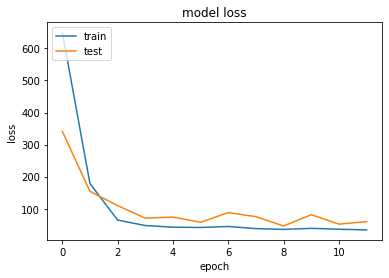

In [28]:
# Define the number of batches
batches_per_epoch=train_generator.n //train_generator.batch_size
r_t = train_top_layer(model, ep=20)

In [ ]:
# Train all layers and selecting the ones we want to hide
r_a = train_all_layers(model,hidden_lay=20, ep=10)

In [29]:
def test_model(model):

    with open(config.CROPPED_IMGS_INFO_FILE, 'r') as f:
        #test_images_info = f.read().splitlines()[-config.TEST_SIZE:]
        test_images_info =f.read().splitlines()[1:config.TEST_SIZE+config.VALIDATION_SIZE]# Reversed

    test_X = []
    test_y = []
    for info in test_images_info:
        weight = float(info.split(',')[config.col])
        test_y.append(weight)
        file_name = info.split(',')[-1]+'.jpg'
        file_path = '%s/%s' % (config.CROPPED_IMGS_DIR, file_name)
        #print(file_path)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (config.RESNET50_DEFAULT_IMG_WIDTH, config.RESNET50_DEFAULT_IMG_WIDTH))
        test_X.append(img)

    test_X = np.array(test_X)
    # test_y are the real weights of the people
    test_y = np.array(test_y)
    pred = model.predict(test_X)
   
    return test_y, pred

In [30]:
y_test, preds = test_model(model)

In [31]:
preds = preds[-1].flatten()

In [32]:
def get_mae(actual, predicted):
    n_samples = len(predicted)
    diff_sum = 0.00
    for i in range(n_samples):
        p = predicted[i]
        a = actual[i]
        d = abs(p - a)
        diff_sum += d
        
    return diff_sum / n_samples

In [33]:
print("MAE - "+str(get_mae(y_test, preds))+' Lbs')

MAE - 28.177360983455884 Lbs


In [34]:
def percent_loss(y_test, preds):
    l = len(y_test)
    perc = 0
    for i in range(len(y_test)):
        perc += abs(y_test[i] - preds[i])/y_test[i]
    print(perc*100//l)
        
        
    

In [35]:
percent_loss(y_test, preds)

15.0


Training top layer...
Epoch 1/20
21/21 [==============================] - 757s 36s/step - loss: 13810.7698 - Output_age_loss: 237.0965 - Output_gender_loss: 9.3016 - Output_race_loss: 8.6038 - weight_estimator_loss: 13555.7677 - Output_gender_acc: 0.3555 - Output_race_acc: 0.4039 - val_loss: 1023.4681 - val_Output_age_loss: 72.2392 - val_Output_gender_loss: 4.8354 - val_Output_race_loss: 12.8945 - val_weight_estimator_loss: 933.4990 - val_Output_gender_acc: 0.7000 - val_Output_race_acc: 0.2000
Epoch 2/20
21/21 [==============================] - 739s 35s/step - loss: 2549.4213 - Output_age_loss: 66.8183 - Output_gender_loss: 4.7913 - Output_race_loss: 8.6147 - weight_estimator_loss: 2469.1970 - Output_gender_acc: 0.6263 - Output_race_acc: 0.4069 - val_loss: 1407.1366 - val_Output_age_loss: 26.9336 - val_Output_gender_loss: 0.6610 - val_Output_race_loss: 3.2236 - val_weight_estimator_loss: 1376.3184 - val_Output_gender_acc: 0.7000 - val_Output_race_acc: 0.8000
Epoch 3/20
21/21 [=========

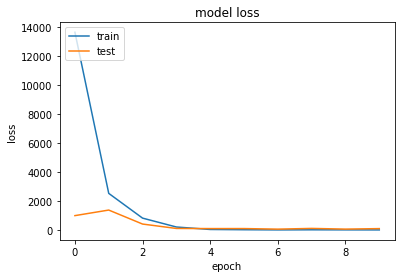

In [42]:
# Define the number of batches
batches_per_epoch=train_generator.n //train_generator.batch_size
r_t = train_top_layer(model_middle, ep=20)

In [47]:
y_test_middle, preds_middle = test_model(model_middle)
